In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
def test_func(x, a=None):
    """
    """
    dim = len(x)
    x = np.asarray(x)
    if a is None:
        a = np.linspace(0.1, .9, dim)
    return [x.dot(a)]

def ishigami(x):
    """
    """
    dim = len(x)
    x = np.asarray(x)
    return [np.sin(x[0]) + 7*np.sin(x[1])**2 + 0.1*x[2]**4 * np.sin(x[0])]

ishigami_true_indices = [0.314, 0.442, 0.]

In [3]:
dim = 3
model = ot.PythonFunction(dim, 1, ishigami)
margins = [ot.Uniform()]*dim
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)

## Sobol indices

In [4]:
columns_first = ['n_sample']
for i in range(dim):
    columns_first.append('S_%d' % (i+1))
    columns_first.append('S_%d_down' % (i+1))
    columns_first.append('S_%d_up' % (i+1))
    
columns_total = ['n_sample']
for i in range(dim):
    columns_total.append('St_%d' % (i+1))
    columns_total.append('St_%d_down' % (i+1))
    columns_total.append('St_%d_up' % (i+1))

In [15]:
n_exp = 10
alpha = 0.95
n_samples = np.linspace(100, 10000, n_exp)
results_first = pd.DataFrame(np.zeros((n_exp, len(columns_first))), columns=columns_first)
results_total = pd.DataFrame(np.zeros((n_exp, len(columns_total))), columns=columns_total)
for k, n_sample in enumerate(n_samples):
    results_first.loc[k, 'n_sample'] = int(n_sample)
    results_total.loc[k, 'n_sample'] = int(n_sample)
    input_design = ot.SobolIndicesAlgorithmImplementation.Generate(input_distribution, int(n_sample), True)
    output_design = model(input_design)
    sensitivity = ot.SaltelliSensitivityAlgorithm(input_design, output_design, int(n_sample))
    sensitivity.setBootstrapConfidenceLevel(alpha)
    indices = np.asarray(sensitivity.getFirstOrderIndices())
    indices_intervals = sensitivity.getFirstOrderIndicesInterval()
    indices_interval_down = np.asarray(indices_intervals.getLowerBound())
    indices_interval_up = np.asarray(indices_intervals.getUpperBound())
    total_indices = np.asarray(sensitivity.getTotalOrderIndices())
    total_indices_intervals = sensitivity.getTotalOrderIndicesInterval()
    total_indices_intervals_down = np.asarray(total_indices_intervals.getLowerBound())
    total_indices_intervals_up = np.asarray(total_indices_intervals.getUpperBound())
    for i in range(dim):
        results_first.loc[k, 'S_%d' % (i+1)] = indices[i]
        results_first.loc[k, 'S_%d_down' % (i+1)] = indices_interval_down[i]
        results_first.loc[k, 'S_%d_up' % (i+1)] = indices_interval_up[i]
        results_total.loc[k, 'St_%d' % (i+1)] = total_indices[i]
        results_total.loc[k, 'St_%d_down' % (i+1)] = total_indices_intervals_down[i]
        results_total.loc[k, 'St_%d_up' % (i+1)] = total_indices_intervals_up[i]

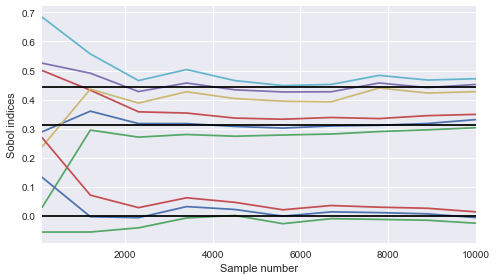

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))
results_first.plot(x='n_sample', legend=False, ax=ax)
x = [n_samples[0], n_samples[-1]]
for i in range(dim):
    true_indice = ishigami_true_indices[i]
    ax.plot(x, [true_indice]*2, 'k')
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

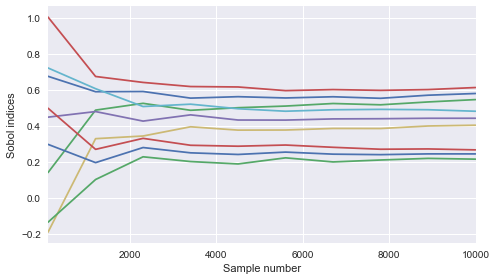

In [17]:
fig, ax = plt.subplots(figsize=(7, 4))
results_total.plot(x='n_sample', legend=False, ax=ax)
ax.set_ylabel('Sobol indices')
ax.set_xlabel('Sample number')
fig.tight_layout()

## Sobol with kriging

In [8]:
n_sample_kriging = 500
input_sample = input_distribution.getSample(n_sample_kriging)
output_sample = model(input_sample)

In [9]:
basis = ot.LinearBasisFactory(dim).build()
covariance = ot.MaternModel(dim)
algo = ot.KrigingAlgorithm(input_sample, output_sample, covariance, basis)
algo.run()
kriging_result = algo.getResult()

In [80]:
n_sample = 1000
input_design = np.asarray(ot.SobolIndicesAlgorithmImplementation.Generate(input_distribution, n_sample, False))
kriging_vector = ot.KrigingRandomVector(kriging_result, input_design)

In [81]:
n_realization = 20
output_designs = np.asarray(kriging_vector.getSample(n_realization)).T

In [84]:
n_samp = input_design.shape[0]
boot_idx = np.random.choice(range(n_samp), n_samp)

In [85]:
input_design[boot_idx]

array([[ 0.74665631, -1.61327456,  1.31610015],
       [-1.53400542,  2.38745881,  1.56626043],
       [-1.6674762 ,  2.16650134, -0.59435703],
       ..., 
       [ 2.40663115, -0.74636096,  1.35874516],
       [ 0.63494512,  0.24523516,  2.96947849],
       [ 1.47961222, -2.03691946,  2.0384697 ]])

In [87]:
alpha = 0.95
n_bootstrap = 50
first_indices = np.zeros((n_realization, dim))
indices = np.zeros((dim, n_realization, n_bootstrap))
n_design = input_design.shape[0]
for i_nz in range(n_realization):
    output_design = output_designs[:, i].reshape(-1, 1)
    sensitivity_normal = ot.SaltelliSensitivityAlgorithm(input_design, output_design, n_sample)
    sensitivity_normal.setBootstrapConfidenceLevel(alpha)
    indices[:, i_nz, 0] = np.asarray(sensitivity_normal.getFirstOrderIndices())
    for i_b in range(1, n_bootstrap):
        boot_idx = np.random.choice(range(n_design), n_design)
        input_design_boot = input_design[boot_idx]
        output_design_boot = output_design[boot_idx]
        sensitivity_boot = ot.SaltelliSensitivityAlgorithm(input_design_boot, output_design_boot, n_sample)
        sensitivity_boot.setBootstrapConfidenceLevel(alpha)
        indices[:, i_nz, i_b] = np.asarray(sensitivity_boot.getFirstOrderIndices())

In [94]:
indices.mean(axis=1).mean(axis=1)

array([ 0.02106732,  0.02576466,  0.00689977])

In [101]:
class KrigingIndices(object):
    """
    """
    def __init__(self, model, input_distribution):
        self.model = model
        self.input_distribution = input_distribution
        self.dim = input_distribution.getDimension()
        
    def build_model(self, n_sample_kriging=100, basis_type='linear', kernel='matern'):
        """
        """
        dim = self.dim
        input_sample = self.input_distribution.getSample(n_sample_kriging)
        output_sample = self.model(input_sample)
        
        if basis_type == 'linear':
            basis = ot.LinearBasisFactory(dim).build()
            
        if kernel == 'matern':
            covariance = ot.MaternModel(dim)
            
        kriging_algo = ot.KrigingAlgorithm(input_sample, output_sample, covariance, basis)
        kriging_algo.run()
        self.kriging_result = kriging_algo.getResult()
        
    def compute_indices(self, n_sample=200, n_realization=10, n_bootstrap=50, confidence_level=0.95, with_second_order=False):
        """
        """
        input_design = np.asarray(ot.SobolIndicesAlgorithmImplementation.Generate(self.input_distribution, n_sample, with_second_order))
        kriging_vector = ot.KrigingRandomVector(self.kriging_result, input_design)
        output_designs = np.asarray(kriging_vector.getSample(n_realization)).T
        
        first_indices = np.zeros((self.dim, n_realization, n_bootstrap))
        n_design = input_design.shape[0]
        for i_nz in range(n_realization):
            output_design = output_designs[:, i].reshape(-1, 1)
            sensitivity_normal = ot.SaltelliSensitivityAlgorithm(input_design, output_design, n_sample)
            sensitivity_normal.setBootstrapConfidenceLevel(alpha)
            first_indices[:, i_nz, 0] = np.asarray(sensitivity_normal.getFirstOrderIndices())
            for i_b in range(1, n_bootstrap):
                boot_idx = np.random.choice(range(n_design), n_design)
                input_design_boot = input_design[boot_idx]
                output_design_boot = output_design[boot_idx]
                sensitivity_boot = ot.SaltelliSensitivityAlgorithm(input_design_boot, output_design_boot, n_sample)
                sensitivity_boot.setBootstrapConfidenceLevel(confidence_level)
                first_indices[:, i_nz, i_b] = np.asarray(sensitivity_boot.getFirstOrderIndices())
                
        return first_indices

In [112]:
kriging = KrigingIndices(model, input_distribution)
kriging.build_model(n_sample_kriging=500)

In [113]:
first_indices = kriging.compute_indices(n_sample=1000, n_realization=50, n_bootstrap=100)

In [116]:
first_indices_estimates = [first_indices[i].mean() for i in range(dim)]
first_indices_estimates

[0.016096898030713933, 0.021864257071772794, 0.0051004518409534785]

In [118]:
first_indices_std = [first_indices[i].std() for i in range(dim)]
first_indices_std

[0.081060108408638726, 0.094107585710013111, 0.043188405547682336]

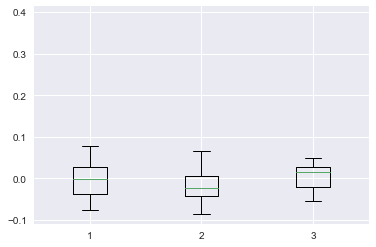

In [124]:
plt.boxplot(first_indices[:, 1, :].T);